Сначала всем нужно немного мотивации...

<img src="https://sun9-76.userapi.com/RzY2Dww7SqDUrRuwqBuXXylR9hQLxtvW0Q11iw/2HhPpaFJwJs.jpg">


Вот теперь можно и начинать!

In [1]:
import pandas as pd
import numpy as np
from statsmodels.api import tsa
import statsmodels.api as sm
import plotly.express as px
from scipy.stats import boxcox
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import OLS
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa import holtwinters as hw
import plotly
import plotly.graph_objs as go

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
import warnings
warnings.filterwarnings("ignore")  #самая важная и нужная вещь в этом ноутбуке!

In [3]:
!pip install statsmodels==0.11.1

     |████████████████████████████████| 8.7MB 2.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [135]:
def acorr_breusch_godfrey(res, nlags=None, store=False):
    x = np.asarray(res.resid).squeeze()
    if x.ndim != 1:
        raise ValueError("Model resid must be a 1d array. Cannot be used on"
                         " multivariate models.")
    exog_old = res.model.exog
    nobs = x.shape[0]
    if nlags is None:
        nlags = min(10, nobs//5)
        nlags = np.trunc(12. * np.power(nobs / 100., 1 / 4.))
        nlags = int(nlags)

    x = np.concatenate((np.zeros(nlags), x))

    xdall = lagmat(x[:, None], nlags, trim="both")
    nobs = xdall.shape[0]
    xdall = np.c_[np.ones((nobs, 1)), xdall]
    xshort = x[-nobs:]

    exog = xdall
    k_vars = exog.shape[1]

    resols = OLS(xshort, exog).fit()
    ft = resols.f_test(np.eye(nlags, k_vars, k_vars - nlags))
    fval = ft.fvalue
    fpval = ft.pvalue
    fval = float(np.squeeze(fval))
    fpval = float(np.squeeze(fpval))
    lm = nobs * resols.rsquared
    lmpval = stats.chi2.sf(lm, nlags)
    # Note: degrees of freedom for LM test is nvars minus constant = usedlags

    if store:
        res_store = ResultsStore()
        res_store.resols = resols
        res_store.usedlag = nlags
        return lm, lmpval, res_store
    else:
        return lm, lmpval

## Загрузка данных

Загрузите данные. В этот раз их не нужно чистить, вся первичная обработка уже произведена. Вся работа будет построена на одном временном ряде. Период данных $-$ неделя. Следующие несколько предложений $-$ описание происхождения данных для тех, кому любопытно, можно пропустить.

Ряд представляет из себя спотовые цены на аммиак на черноморском базисе. Базис $-$ это некоторая агрегированная точка, включающая в себя несколько различных портов. Это сделано для того, чтобы получить некоторую агрегированную цену региона, уменьшив количество входных данных. Для репрезентативности цены в базисе взвешиваются на объёмы торгов в каждом порту. Эта схема отражает то, как устроены мировые товарные рынки. На некоторые товары нет общей единой мировой цены (как, например, нефть марки Brent), но есть региональная цена. Для справки: cпотовые цены $-$ цены, по которым продаются реальные товары или реальные бумаги в данный момент времени на условиях немедленной доставки. Также цены товарных рынков обычно подчиняются принципам организации поставок. Например, данные цены использовали принцип FOB, который означает, что с момента пересечения поручней судна в порту отгрузки покупатель несёт на себе как риски, так и все расходы. Считается, что продавец в этот момент выполнил все свои обязательства.

#### Задание 1 (0.5 баллов)
Визуализируйте данные. Какие характерные особенности данных, которые помогут впоследствии построить модель, вы можете идентифицировать?

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [138]:
df = pd.read_csv('/content/gdrive/My Drive/hw_data.csv')

In [7]:
df

,date,value
0,2004-09-19,243.0
1,2004-09-26,242.5
2,2004-10-03,243.5
3,2004-10-10,243.5
4,2004-10-17,243.5
...,...,...
795,2019-12-15,218.5
796,2019-12-22,218.5
797,2019-12-29,218.5
798,2020-01-05,219.5


In [8]:
fig = px.line(x=df['date'], y=df['value']);
fig.update_layout(title='График спотовых цен на аммиак на черноморском базисе',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.update_xaxes(rangeslider_visible=True);
fig.show()

Особенности данных, заметные по графику:
 
 1) Июль-октябрь 2008 аномально большие значения данных

 2) Дисперсия ряда не однородна в течение всего промежутка измерений

 3) Ковариация данных не постоянна

 4) Математическое ожидание не постоянно

 5) С 2017 по 2019 год пристуствует сезонность с периодом примерно 11 месяцев

 => ряд не является стационарным

#### Задание 2 (1 балл)

Как вы можете видеть, дисперсия временного ряда на различных участках неоднородна. Используйте какое-то преобразование (логарифмы, степени, показательные функции и прочие монотонные и обратимые преобразования преобразования), которое это немного подкорректирует. Безусловно, тут дисперсия кластеризуется, но этот эффект можно попытаться несколько уменьшить. Должно получиться что-то в духе картинки ниже, хотя визуально направления трендов могут различаться. (Например, если вы будете возводить в отрицательную степень). Абсолютно не обязательно, что сохранится исходный рисунок трендов.

Результат этого пункта необязательно использовать далее, можно работать с исходным рядом, подразумевая, что отсутствие преобразований будет заменено корректировками уже на отборе моделей (Так можно делать для ETS, например, когда вы хотите реализовать мультипликативную модель, что обсуждалось на лекции. Но лучше преобразовать. Для моделей ARIMA преобразование будет сделать необходимо, если возможно). Все прогнозы необходимо получить в исходных значениях (заказчику обычно нужен прогноз цены, а не экспоненты от степени цены), поэтому трансформацию нужно производить только для тренировочной части, а на прогнозах модели перед подсчётам метрики производить обратное преобразование. Обязательно учтите этот факт при написании заданий на кросс-валидацию.

In [9]:
fig = px.line(x=df['date'], y=np.log(df['value']) / 20);
fig.update_layout(title='Исходный ряд после стабилизации дисперсии',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.update_xaxes(rangeslider_visible=True);
fig.show()

Ну, вроде, стало получше... Теперь разброс дисперсии не такой большой, так как все блоки находятся примерно на одном уровне. 

Так как указано, что результат не обязательно использовать дальше, то я этого делать и не буду. Дабы не усложнять себе жизнь. 

Пока (до ARIM-ы) можно жить без сведения ряда к стационарному, значит будем жить...

#### Задание 3 (0.5 баллов)
Разделите выборку на тренировочную и валидационную. Валидационная $-$ последние 30 наблюдений, тренировочная $-$ всё остальное. 

In [139]:
train = df[:-30]
valid = df[-30:]

#### Задание 4 (3 балла)
Руководствуясь теми паттернами, которые вы выделили ранее, выберите 3-5 моделей-кандидатов из класса ETS. Кратко поясните, почему была выбрана каждая модель. На тренировочной части временного ряда обучите все модели-кандидаты. Отберите две лучших по любому информационному критерию из доступных.


Мною было решено выбрать следующий модели:

1) Простое экспоненциальное сглаживание, ETS(A,N,N).
Самая простая модель. Интересно посмотреть, насколько хуже/лучше она будет по сравнению с более сложными. Зачастую наивные модели работают даже лучше из-за отстутствия переобучения.

2) ETS(A,A,A) с сезонностью = 50. Сезонность 50 выбрана так, потому что 50 недель - примерно 11 месяцев, а последние 3 года в ряде наблюдается такая сезонность.

3) Модель Холинга, ETS(A,A,N) с затухающим трендом. Примерно с 2013 года в ряде прослеживается затухающий тренд.

4) ETS(A,N,A) с сезонность снова 50.

Все мультипликативные модели на нашем ряде не работали, так что и не будем их использовать. Все логично.


ETS(A, N, N):


In [140]:
mod1 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values)
res1 = mod1.fit()
print(res1.summary())

forecs = res1.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'].values, y=df['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, N, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()


                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  770
Model:                   ETS(A, N, N)   Log Likelihood               -3354.380
Date:                Sun, 18 Oct 2020   AIC                           6714.759
Time:                        18:28:05   BIC                           6728.699
Sample:                             0   HQIC                          6720.124
                                - 770   Scale                          355.953
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.012     80.912      0.000       0.976       1.024
initial_level     242.9999   7.36e-13    3.3e+14      0.000     243.000     243.000
Ljung-Box (Q):                  

Посмотрим на прогноз поближе

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, N, N)'))
prod.update_layout(title='Результат прогноза модели ETS(A, N, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
prod.show()

ETS(A, A, A):

In [141]:
mod2 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, trend="add", seasonal=50)
res2 = mod2.fit(maxiter=100)
print(res2.summary())


forecs = res2.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'].values, y=df['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, A, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()


                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  770
Model:                   ETS(A, A, A)   Log Likelihood               -3330.552
Date:                Sun, 18 Oct 2020   AIC                           6771.104
Time:                        18:30:05   BIC                           7026.656
Sample:                             0   HQIC                          6869.453
                                - 770   Scale                          334.591
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.024     42.260      0.000       0.954       1.046
smoothing_trend         0.0001      0.006      0.016      0.987      -0.012       0.012
smoothing_season

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, A, A)'))
prod.update_layout(title='Результат прогноза модели ETS(A, A, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
prod.show()

ETS(A, A, N):

In [142]:
mod3 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, trend=True, damped_trend=True)
res3 = mod3.fit()
print(res3.summary())


forecs = res3.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'].values, y=df['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, A, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()


                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  770
Model:                  ETS(A, Ad, N)   Log Likelihood               -3267.473
Date:                Sun, 18 Oct 2020   AIC                           6546.945
Time:                        18:30:07   BIC                           6574.823
Sample:                             0   HQIC                          6557.674
                                - 770   Scale                          284.026
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8538      0.026     32.920      0.000       0.803       0.905
smoothing_trend     0.4415      0.029     15.460      0.000       0.385       0.497
damping_trend       0.8000      

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, A, N)'))
prod.update_layout(title='Результат прогноза модели ETS(A, A, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
prod.show()

ETS(A, N, A):

In [143]:
mod4 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, seasonal=50)
res4 = mod4.fit()
print(res4.summary())

forecs = res4.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'].values, y=df['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, N, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()

                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  770
Model:                   ETS(A, N, A)   Log Likelihood               -3331.112
Date:                Sun, 18 Oct 2020   AIC                           6768.223
Time:                        18:30:56   BIC                           7014.482
Sample:                             0   HQIC                          6862.995
                                - 770   Scale                          335.077
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.023     42.583      0.000       0.954       1.046
smoothing_seasonal      0.0001      0.031      0.003      0.997      -0.061       0.061
initial_level   

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, N, A)'))
prod.update_layout(title='Результат прогноза модели ETS(A, N, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
prod.show()

Теперь выберем 2 лучших модели. Рассмотрим в качестве информационного критерия AIC.

У нас по моделям вышло следующее:

ETS(A, N, N): AIC = 6714.759

ETS(A, A, A): AIC = 6771.104

ETS(A, A, N): AIC = 6546.945

ETS(A, N, A): AIC = 6768.223

Это немного противоречит тому, что можно видеть на графиках, но лучшими оказались модели ETS(A, N, N), ETS(A, A, N). Видимо более сложные модели. учитывающие сезонность, переобучились. Что в целом объяснимо, ведь указанная сезонность в ряде наблюдалась под конец. То есть модель просто подстроилась на значения рада в не очень большом временном интервале.

#### Задание 5 (2 балла)
С помощью теста Бройша-Годфри протестируйте наличие автокорреляций в остатках каждой из моделей. Для этого воспользуйтесь функцией, определённой в начале тетрадки. Это слегка исправленная функция из statsmodels, модифицированная взаимодействовать с результатом оценки ETS-моделей, а именно с объектом, возвращаемым методом fit() (Как из sm.tsa.ExponentialSmoothing,  так и из sm.tsa.statespace.ExponentialSmoothing).  Визуализируйте автокорреляции остатков для каждой из моделей по аналогии с семинаром. Получилось ли добиться некоррелированных остатков хотя бы в одной модели? Если нет, то предположите почему.

Результат теста Бройша-Годфри для ETS(A, N, N): (234.0711699395448, 5.112334036577479e-39)


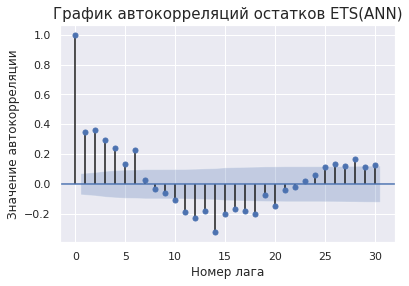

In [144]:
print('Результат теста Бройша-Годфри для ETS(A, N, N):', acorr_breusch_godfrey(res1))
resid = res1.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(ANN)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, A, A): (234.72104664561792, 3.7813149624060684e-39)


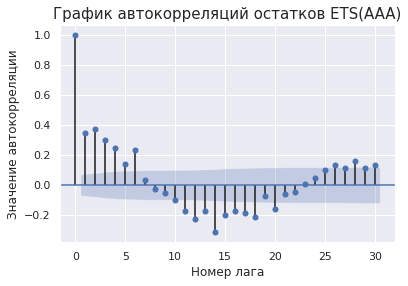

In [145]:
print('Результат теста Бройша-Годфри для ETS(A, A, A):', acorr_breusch_godfrey(res2))
resid = res2.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(AAA)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, A, N): (96.62897224677236, 2.1735626420294898e-12)


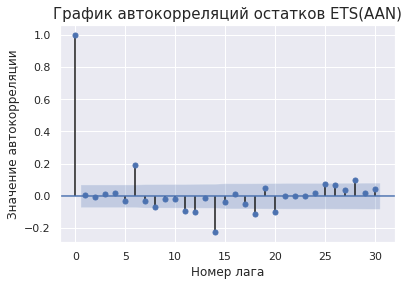

In [146]:
print('Результат теста Бройша-Годфри для ETS(A, A, N):', acorr_breusch_godfrey(res3))
resid = res3.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(AAN)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, N, A): (235.2077670487479, 3.016691234061919e-39)


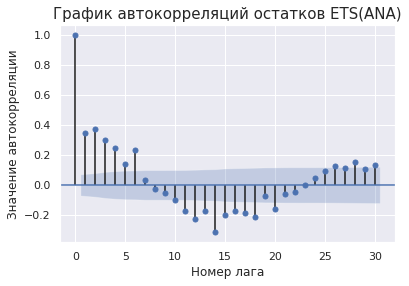

In [147]:
print('Результат теста Бройша-Годфри для ETS(A, N, A):', acorr_breusch_godfrey(res4))
resid = res4.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(ANA)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Как мы можем видеть, ни для одной из моделей не получилось добиться некоррелированных остатков.
Результат теста Бройша-Годфри для всех моделей в разы больше $\chi^2$ критического с двумя степенями свободы ($\approx 5,99$). Таким образом гипотеза о том, что автокорреляция отсутствует не принимается. 

Ни в одной из моделей не получилось добиться некореллированных остатков. Думаю, что это произошло потому что либо тестируемые мною модели были слишком простыми, не учитывающими почти особенности ряда, либо такими, что наоборот переучивались. Следовательно вышло так, что остатки модели остались значимыми, то есть автокореллированными, то есть они все еще несут в себе некоторую информацию о ряде и ценны для прогноза, не являются шумом. 

#### Задание 6 (1 балл)
Вне зависимости от результатов предыдущего пункта, оцените ошибку прогноза с помощью кросс-валидации любым из двух методов (сдвигающееся или расширяющееся окно). Аналогично оцените ошибку для наивной модели. Удалось ли вашей модели побить наивный прогноз?

Оценю ошибки для моделей, победивших по информационному критерию AIC.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [80]:
def formodel1(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    exp = sm.tsa.statespace.ExponentialSmoothing(tr, trend=True, damped_trend=True)
    res = exp.fit()

    forecs = res.get_forecast(len(te)).summary_frame()['mean']
    return metric(te, forecs)

In [81]:
# Расширяющееся окно
a = df['value'].expanding(400).apply(lambda x: formodel1(x, metric = mean_absolute_error))

In [89]:
print('Результат кросс-валидации для ETS(A, A, N):', a[399:].mean())

Результат кросс-валидации для ETS(A, A, N): 102.81034658598263


In [83]:
def formodel2(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    exp = sm.tsa.statespace.ExponentialSmoothing(tr)
    res = exp.fit()

    forecs = res.get_forecast(len(te)).summary_frame()['mean']
    return metric(te, forecs)

In [84]:
b = df['value'].expanding(400).apply(lambda x: formodel2(x, metric = mean_absolute_error))

In [85]:
print('Результат кросс-валидации для ETS(A, N, N):', b[399:].mean())

Результат кросс-валидации для ETS(A, N, N): 100.38979786773518


Теперь посмотрим на результат кросс-валидации для наивной модели.

In [86]:
def formodel3(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    forecs = [tr.values[-1] for i in range(len(te))]
    return metric(te.values, forecs)

In [87]:
c = df['value'].expanding(400).apply(lambda x: formodel3(x, metric = mean_absolute_error))

In [88]:
print('Результат кросс-валидации для наивной модели:', c[399:].mean())

Результат кросс-валидации для наивной модели: 100.38969478842671


Ни одна из моделей не смогла победить наивную. У нее значения ошибки хоть не сильно, но меньше..

#### Задание 7 (2 балла)
Оставьте в тренировочной выборке только последние 400 наблюдений и повторите задания 4-6. Изменились ли результаты теста на наличие автокорреляций в остатках (если результат теста не изменился, то улучшилось ли значение p-value)? Улучшилось ли качество прогнозов модели? Если да, то как Вы думаете, почему?

In [126]:
df_430 = df.tail(430)

In [127]:
train = train.tail(400)

In [128]:
mod1 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values)
res1 = mod1.fit()
print(res1.summary())

forecs = res1.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_430['date'].values, y=df_430['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, N, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()


                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  400
Model:                   ETS(A, N, N)   Log Likelihood               -1583.901
Date:                Sun, 18 Oct 2020   AIC                           3173.802
Time:                        18:19:24   BIC                           3185.777
Sample:                             0   HQIC                          3178.544
                                - 400   Scale                          161.036
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.038     26.133      0.000       0.925       1.075
initial_level     620.0011   1.12e+05      0.006      0.996   -2.19e+05     2.2e+05
Ljung-Box (Q):                  

Ну тут все ясно, не будем даже смотреть ближе на прогноз.

In [129]:
mod2 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, trend="add", seasonal=50)
res2 = mod2.fit(maxiter=100)
print(res2.summary())


forecs = res2.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_430['date'].values, y=df_430['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, A, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()

                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  400
Model:                   ETS(A, A, A)   Log Likelihood               -1557.666
Date:                Sun, 18 Oct 2020   AIC                           3225.332
Time:                        18:20:27   BIC                           3444.862
Sample:                             0   HQIC                          3312.269
                                - 400   Scale                          141.239
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.061     16.518      0.000       0.881       1.119
smoothing_trend         0.0001      0.009      0.011      0.991      -0.018       0.018
smoothing_season

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, A, A)'))
prod.update_layout(title='Результат прогноза модели ETS(A, A, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
prod.show()

In [130]:
mod3 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, trend=True, damped_trend=True) 
res3 = mod3.fit()
print(res3.summary())


forecs = res3.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_430['date'].values, y=df_430['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, A, N)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()

                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  400
Model:                  ETS(A, Ad, N)   Log Likelihood               -1544.311
Date:                Sun, 18 Oct 2020   AIC                           3100.621
Time:                        18:20:28   BIC                           3124.570
Sample:                             0   HQIC                          3110.105
                                - 400   Scale                          132.115
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.059     17.088      0.000       0.885       1.115
smoothing_trend     0.2840      0.071      4.017      0.000       0.145       0.423
damping_trend       0.8541      

Тут тоже не будем смотреть ближе. 

In [131]:
mod4 = sm.tsa.statespace.ExponentialSmoothing(train['value'].values, seasonal=50)
res4 = mod4.fit()
print(res4.summary())

forecs = res4.get_forecast(30).summary_frame()
forecs.index = valid['date'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_430['date'].values, y=df_430['value'].values, name='Исходный ряд'))
fig.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name="Прогноз модели"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Результат прогноза модели ETS(A, N, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена');
fig.show()

                        Exponential Smoothing Results                         
Dep. Variable:                      y   No. Observations:                  400
Model:                   ETS(A, N, A)   Log Likelihood               -1578.759
Date:                Sun, 18 Oct 2020   AIC                           3263.518
Time:                        18:20:54   BIC                           3475.066
Sample:                             0   HQIC                          3347.294
                                - 400   Scale                          156.949
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.061     16.476      0.000       0.881       1.119
smoothing_seasonal      0.0001      0.051      0.002      0.998      -0.101       0.101
initial_level   

In [ ]:
prod = go.Figure()
prod.add_trace(go.Scatter(x=valid['date'].values, y=valid['value'].values, name='Значения ряда'))
prod.add_trace(go.Scatter(x=forecs.index, y=forecs['mean'], name='Прогноз модели ETS(A, N, A)'))
prod.update_layout(title='Результат прогноза модели ETS(A, N, A)',
                   xaxis_title='Время',
                   yaxis_title='Цена')
prod.show()

По информационному критерию AIC у нас вышло следующее:

ETS(A, N, N): AIC = 3185.777

ETS(A, A, A): AIC = 3225.332

ETS(A, A, N): AIC = 3100.621

ETS(A, N, A): AIC = 3263.518

Таким образом опять лучшими являются ETS(A, N, N) и ETS(A, A, N)

Результат теста Бройша-Годфри для ETS(A, N, N): (91.01875713208392, 1.6233311467598852e-12)


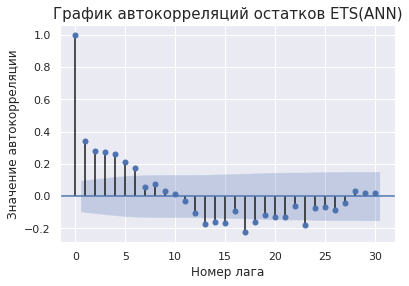

In [132]:
print('Результат теста Бройша-Годфри для ETS(A, N, N):', acorr_breusch_godfrey(res1))
resid = res1.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(ANN)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, A, A): (95.9631942654049, 1.966633284089048e-13)


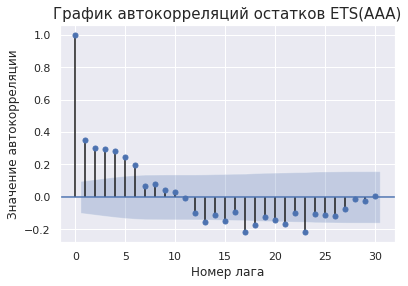

In [133]:
print('Результат теста Бройша-Годфри для ETS(A, A, A):', acorr_breusch_godfrey(res2))
resid = res2.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(AAA)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, A, N): (22.171169264855006, 0.13775021834497816)


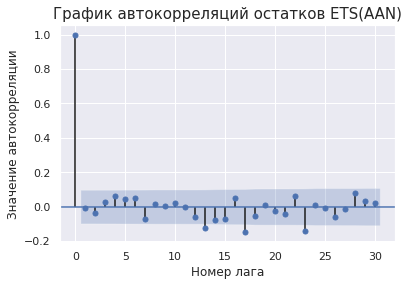

In [134]:
print('Результат теста Бройша-Годфри для ETS(A, A, N):', acorr_breusch_godfrey(res3))
resid = res3.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(AAN)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Результат теста Бройша-Годфри для ETS(A, N, A): (109.0997127872519, 6.649440782960033e-16)


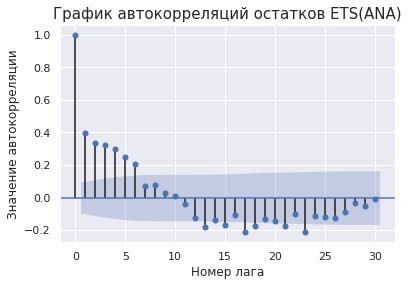

In [136]:
print('Результат теста Бройша-Годфри для ETS(A, N, A):', acorr_breusch_godfrey(res4))
resid = res4.resid
sm.graphics.tsa.plot_acf(resid, lags=30)
plt.title('График автокорреляций остатков ETS(ANA)', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Как мы видим, значение теста Бройша-Годфри сильно уменьшилось. Но при этом все еще ни одна из моделей не лишена автокорелляций в остатках.

Но рассматорим значения p-value.

P-value было:

ETS(ANN) - 5.112334036577479e-39

ETS(AAA) - 3.7813149624060684e-39

ETS(AAN) - 2.1735626420294898e-12

ETS(ANA) - 3.016691234061919e-39

P-value стало:

ETS(ANN) - 1.6233311467598852e-12

ETS(AAA) - 1.966633284089048e-13

ETS(AAN) - 0.13775021834497816

ETS(ANA) - 6.649440782960033e-16

Мы знаем, что p-value - Это вероятность получить наши данные при условии нулевой гиптезы. То есть в нашем случаи при условии отсутствия автокорелляций в остатках. Таким образом при уменьшении выборки p-value улучшилось. В случае ETS(ANN) вероятность стала даже больше 1/10, что неплохо.

In [93]:
def formodel1(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    exp = sm.tsa.statespace.ExponentialSmoothing(tr, trend=True, damped_trend=True)
    res = exp.fit()

    forecs = res.get_forecast(len(te)).summary_frame()['mean']
    return metric(te, forecs)

In [94]:
# Расширяющееся окно
a = df_430['value'].expanding(400).apply(lambda x: formodel1(x, metric = mean_absolute_error))

In [95]:
print('Результат кросс-валидации для ETS(A, A, N):', a[399:].mean())

Результат кросс-валидации для ETS(A, A, N): 55.14098297235542


In [96]:
def formodel2(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    exp = sm.tsa.statespace.ExponentialSmoothing(tr)
    res = exp.fit()

    forecs = res.get_forecast(len(te)).summary_frame()['mean']
    return metric(te, forecs)

In [97]:
b = df_430['value'].expanding(400).apply(lambda x: formodel2(x, metric = mean_absolute_error))

In [98]:
print('Результат кросс-валидации для ETS(A, N, N):', b[399:].mean())

Результат кросс-валидации для ETS(A, N, N): 46.801672939726444


In [99]:
def formodel3(ts, metric = mean_squared_error):
    tr = ts.head(int(len(ts) * 0.8))
    te = ts.tail(len(ts) - len(tr))
    forecs = [tr.values[-1] for i in range(len(te))]
    return metric(te.values, forecs)

In [100]:
c = df_430['value'].expanding(400).apply(lambda x: formodel3(x, metric = mean_absolute_error))

In [103]:
print('Результат кросс-валидации для наивной модели:', c[399:].mean())

Результат кросс-валидации для наивной модели: 46.80162494752791


На этот раз также ошибка на кросс-валидации у наивной модели немного меньше.

И в целом ошибки у всех моделей стали меньше. Думаю, так произошло потому что при отсчении последних 430 значений ряда мы как раз отсекли ту его часть, где нет резких перепадов - пиков и спадов. (В частности теперь в выборке нет 2008 года, который очень выделялся на фоне остальных). Таким образом ошибка у предсказания стала меньше.